### Imports

In [11]:
# Data Management
import pandas as pd
import numpy as np

# Data Preprocessing
from sklearn.preprocessing import StandardScaler

# Unsupervised Learning
from sklearn.decomposition import PCA

# Deep Learning
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader

# Visualization
import matplotlib.pyplot as plt

### Data Extraction

In [3]:
df = pd.read_csv('../1_Unsupervised/data/etf_pairs.csv')
df.drop(columns=['Date'],inplace=True)
df

,asset_1,asset_2,spread,z_score
0,50.461056,42.633717,-6.816010,-2.005521
1,50.401669,42.593018,-6.820720,-1.966081
2,49.999657,42.503490,-7.102455,-2.102464
3,49.967682,42.487202,-7.112546,-2.051592
4,50.931583,42.804634,-6.575105,-1.671952
...,...,...,...,...
1656,81.379997,57.259998,4.452979,2.132583
1657,82.400002,57.540001,5.096808,2.412733
1658,82.699997,57.889999,4.926592,2.285733
1659,82.370003,57.919998,4.556295,2.069805


In [4]:
# Feature Engineering

df['log_return_1'] = np.log(df['asset_1'] / df['asset_1'].shift(1))
df['log_return_2'] = np.log(df['asset_2'] / df['asset_2'].shift(1))

df['rolling_log_return_1'] = df['log_return_1'].rolling(21).mean()
df['rolling_log_return_2'] = df['log_return_2'].rolling(21).mean()

df['prod_return_1'] = df['log_return_1'].cumsum()
df['prod_return_2'] = df['log_return_2'].cumsum()

df.dropna(inplace=True)
df.tail(3)

,asset_1,asset_2,spread,z_score,log_return_1,log_return_2,rolling_log_return_1,rolling_log_return_2,prod_return_1,prod_return_2
1658,82.699997,57.889999,4.926592,2.285733,0.003634,0.006064,0.006647,0.002487,0.494018,0.305899
1659,82.370003,57.919998,4.556295,2.069805,-0.003998,0.000518,0.006661,0.002350,0.490019,0.306417
1660,81.099998,57.959999,3.232551,1.431051,-0.015538,0.000690,0.005670,0.002400,0.474481,0.307108


Text(0.5, 1.0, 'Z Score')

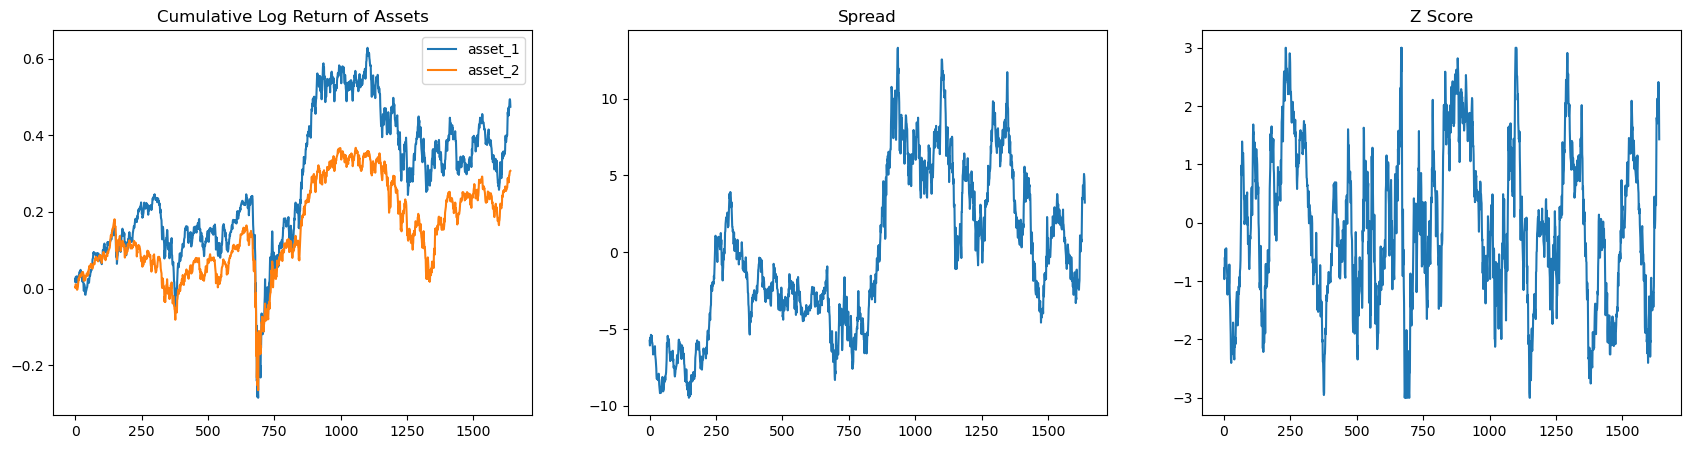

In [5]:
# Visualize the Data

fig=plt.figure(figsize=(21,5))

plt.subplot(1,3,1)
plt.plot(df['prod_return_1'].values,label='asset_1')
plt.plot(df['prod_return_2'].values,label='asset_2')
plt.legend()
plt.title('Cumulative Log Return of Assets')

plt.subplot(1,3,2)
plt.plot(df['spread'].values,label='spread')
plt.title('Spread')
plt.subplot(1,3,3)
plt.plot(df['z_score'].values,label='spread')
plt.title('Z Score')

### Build Neural Network

In [6]:
# Add target
df['target']=0

df.loc[df['spread'].shift(-1)>0,'target']=1
df.dropna(inplace=True)

In [7]:
# Split the Data
X_data = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

In [10]:
# Feature Scaling
scaler=StandardScaler()
X=scaler.fit_transform(X_data)
X[:3]

array([[-1.27384246, -1.20682176, -1.10653209, -0.57793616,  0.08988561,
         0.23387799,  0.27000946,  0.00520436, -1.36380228, -1.24406806],
       [-1.31118168, -1.22366859, -1.16770154, -0.71747763, -0.56844197,
        -0.21613502,  0.16708265, -0.02035305, -1.41253259, -1.26374052],
       [-1.24953842, -1.15346953, -1.13245361, -0.61529949,  0.88920235,
         0.81405218,  0.47441376,  0.20029674, -1.33230756, -1.18206548]])

### Data Structure

In [13]:
class dataset(Dataset):
    def __init__(self,X,y):
        self.X=torch.tensor(X,dtype=torch.float)
        self.y=torch.tensor(y,dtype=torch.float)        
        self.len=self.X.shape[0]
    def __getitem__(self,index):
        return self.X[index],self.y[index]
    def __len__(self):
        return self.len
    
trainset=dataset(X,y)
trainloader=DataLoader(trainset,batch_size=32,shuffle=False)

In [14]:
class Network(nn.Module):
    def __init__(self,input_shape):
        super(Network,self).__init__()
        self.fc1 = nn.Linear(input_shape,16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

### Train Model

In [18]:
# Hyperparameters
learning_rate = 0.08
epochs = 1000


model = Network(input_shape=X.shape[1])
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn=nn.BCELoss()

In [19]:
# Forward Loop

losses=[]
accuracy=[]

for i in range(epochs):
    for j,(X_train,y_train) in enumerate(trainloader):
       output = model(X_train)
       loss = loss_fn(output,y_train.reshape(-1,1))
       prediction = model(torch.tensor(X,dtype=torch.float32))
       acc = (prediction.detach().numpy().round()==y).mean()
       optimizer.zero_grad()
       loss.backward()
       optimizer.step()

       if i%100==0:
           print('Epoch: {} - Loss: {} - Accuracy: {}'.format(i,loss.item(),acc))
           losses.append(loss.item())
           accuracy.append(acc)
       

Epoch: 0 - Loss: 0.7694278359413147 - Accuracy: 0.4445121951219512
Epoch: 1 - Loss: 0.0038142800331115723 - Accuracy: 0.5004736763831052
Epoch: 2 - Loss: 0.0 - Accuracy: 0.5069021415823914
Epoch: 3 - Loss: 2.4539107471355237e-05 - Accuracy: 0.5033157346817371
Epoch: 4 - Loss: 3.725290298461914e-09 - Accuracy: 0.5046690957763236
Epoch: 5 - Loss: 9.872020712009544e-08 - Accuracy: 0.504330755502677
Epoch: 6 - Loss: 0.0 - Accuracy: 0.5055487804878048
Epoch: 7 - Loss: 4.1909535752893134e-07 - Accuracy: 0.5037217430101131
Epoch: 8 - Loss: 1.30385160446167e-08 - Accuracy: 0.5066991374182035
Epoch: 9 - Loss: 2.1234160385574796e-07 - Accuracy: 0.5057517846519929
Epoch: 10 - Loss: 0.0 - Accuracy: 0.5054811124330756
Epoch: 11 - Loss: 1.862645149230957e-09 - Accuracy: 0.5052104402141583
Epoch: 12 - Loss: 0.0 - Accuracy: 0.5064284651992862
Epoch: 13 - Loss: 1.30385160446167e-08 - Accuracy: 0.5046690957763236
Epoch: 14 - Loss: 0.0 - Accuracy: 0.50703747769185
Epoch: 15 - Loss: 2.2351741790771484e-08